In [1]:
spark 

In [2]:
dir0 = 'file:///home/cloudera/2.kkbox_churn/data01/'

In [3]:
df0_ = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true') \
            .load(dir0+'transactions-v1_members-no-renew.csv')
df0_.printSchema()

root
 |-- msno: string (nullable = true)
 |-- payment_method: integer (nullable = true)
 |-- plan_days: integer (nullable = true)
 |-- list_price: integer (nullable = true)
 |-- actual_paid: integer (nullable = true)
 |-- is_auto_renew: integer (nullable = true)
 |-- trans_date: integer (nullable = true)
 |-- exp_date: integer (nullable = true)
 |-- is_cancel: integer (nullable = true)



In [7]:
# check
df0_.where('is_auto_renew != 0').count()  # should be 0

0

In [8]:
df0_.where('is_cancel != 0').count()  # should be 0

0

In [4]:
df0 = df0_.drop('is_auto_renew').drop('is_cancel')
df0.show(3)

+--------------------+--------------+---------+----------+-----------+----------+--------+
|                msno|payment_method|plan_days|list_price|actual_paid|trans_date|exp_date|
+--------------------+--------------+---------+----------+-----------+----------+--------+
|++XNdJjfGpF5k/o25...|            38|       30|       149|        149|  20151107|20151207|
|++XNdJjfGpF5k/o25...|            38|       90|       447|        447|  20160104|20160403|
|++wYPELMJ2byTXrC7...|            38|      360|      1200|       1200|  20160205|20170130|
+--------------------+--------------+---------+----------+-----------+----------+--------+
only showing top 3 rows



In [17]:
df0.count()

1821142

In [4]:
Nmem0 = df0.groupBy('msno').count().count()
print(Nmem0)

651043


# plan_days

In [5]:
df1 = df0.groupBy('plan_days').count() \
      .sort('plan_days')
df1.show(40)

+---------+-------+
|plan_days|  count|
+---------+-------+
|        1|    795|
|        2|     53|
|        3|     40|
|        7| 354203|
|       10|  34266|
|       14|    724|
|       15|      5|
|       21|    156|
|       30|1279481|
|       35|    681|
|       45|   1080|
|       60|   4465|
|       66|    147|
|       70|    285|
|       80|    172|
|       90|   4929|
|       99|    273|
|      100|  17158|
|      110|    137|
|      120|   9321|
|      180|  27514|
|      195|  51653|
|      200|   3758|
|      230|     38|
|      240|   1016|
|      270|     60|
|      360|   2761|
|      365|    139|
|      395|   3047|
|      400|    953|
|      410|  21613|
|      415|      1|
|      450|    218|
+---------+-------+



## trans_date vs. plan_days

In [6]:
from pyspark.sql.functions import count, max, min
df1 = df0.groupBy('plan_days') \
        .agg(count("*").alias('count'), 
             min('trans_date').alias('min_trans_date'),
             max('trans_date').alias('max_trans_date')
            ) \
        .sort('plan_days')

In [7]:
df1.show(40)

+---------+-------+--------------+--------------+
|plan_days|  count|min_trans_date|max_trans_date|
+---------+-------+--------------+--------------+
|        1|    795|      20151102|      20170228|
|        2|     53|      20151103|      20170126|
|        3|     40|      20151114|      20170224|
|        7| 354203|      20151101|      20170228|
|       10|  34266|      20151101|      20170228|
|       14|    724|      20151116|      20170105|
|       15|      5|      20151112|      20151228|
|       21|    156|      20151101|      20170114|
|       30|1279481|      20151101|      20170228|
|       35|    681|      20151215|      20161123|
|       45|   1080|      20170124|      20170206|
|       60|   4465|      20151101|      20170228|
|       66|    147|      20160531|      20160708|
|       70|    285|      20151102|      20170117|
|       80|    172|      20151105|      20170108|
|       90|   4929|      20151101|      20161231|
|       99|    273|      20160202|      20160921|


In [8]:
def month_No_since_201501(date_int):
    '''returns an integer'''
    ym = date_int // 100
    yr = ym // 100
    mn = ym % 100
    return (yr - 2015)*12 + mn

from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
get_month_No = udf(month_No_since_201501, IntegerType())

In [9]:
from pyspark.sql.functions import col
df2 = df1.withColumn('min_trans_date_mno', get_month_No('min_trans_date')) \
         .withColumn('max_trans_date_mno', get_month_No('max_trans_date'))

In [10]:
df2.show(3)

+---------+-----+--------------+--------------+------------------+------------------+
|plan_days|count|min_trans_date|max_trans_date|min_trans_date_mno|max_trans_date_mno|
+---------+-----+--------------+--------------+------------------+------------------+
|        1|  795|      20151102|      20170228|                11|                26|
|        2|   53|      20151103|      20170126|                11|                25|
|        3|   40|      20151114|      20170224|                11|                26|
+---------+-----+--------------+--------------+------------------+------------------+
only showing top 3 rows



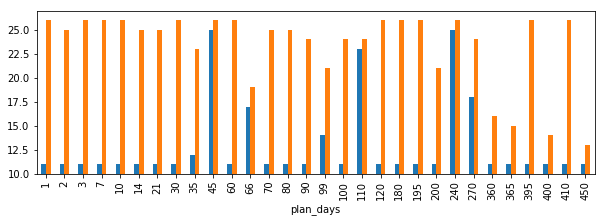

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df2.where('count >= 40') \
   .select('plan_days', 'min_trans_date_mno', 'max_trans_date_mno') \
   .toPandas().set_index('plan_days').plot(kind='bar', figsize=(10,3), ylim=(10,27), legend=False)
plt.show()

# list_price = 0

In [80]:
df3.show(3)

+--------------------+----------+---------+----------+----------+----------+-----------------+
|                msno|list_price|plan_days|trans_date|start_date|  exp_date|start_minus_trans|
+--------------------+----------+---------+----------+----------+----------+-----------------+
|nuNWXAG/T41m2CTNT...|       149|       30|2016-01-25|2016-01-25|2016-02-24|                0|
|nuNWXAG/T41m2CTNT...|       149|       30|2016-06-09|2016-06-10|2016-07-09|                1|
|nuNWXAG/T41m2CTNT...|       149|       30|2015-11-20|2015-11-21|2015-12-20|                1|
+--------------------+----------+---------+----------+----------+----------+-----------------+
only showing top 3 rows



In [94]:
from pyspark.sql.functions import col, datediff
df4 = df3.where('list_price = 0') \
         .select(datediff('exp_date', 'trans_date').alias('exp_minus_trans'))
df4.describe().show()

+-------+------------------+
|summary|   exp_minus_trans|
+-------+------------------+
|  count|            390061|
|   mean|11.405062285129763|
| stddev|26.974195795130967|
|    min|                -8|
|    max|               480|
+-------+------------------+



In [96]:
df4.where('exp_minus_trans < 0').count()

55

In [99]:
df4.where('exp_minus_trans < 0') \
   .groupBy('exp_minus_trans').count() \
   .sort('exp_minus_trans').show()

+---------------+-----+
|exp_minus_trans|count|
+---------------+-----+
|             -8|    1|
|             -4|    2|
|             -3|   12|
|             -2|   32|
|             -1|    8|
+---------------+-----+



# number of records for each member 

In [25]:
from pyspark.sql.functions import count, sum
df1 = df0.groupBy('msno') \
         .agg(count('*').alias('count_trans'), sum('plan_days').alias('sum_days'))
df1.show(10)

+--------------------+-----------+--------+
|                msno|count_trans|sum_days|
+--------------------+-----------+--------+
|++7jKYbuIJPXry8Oh...|          1|      10|
|+0RJtbyhoPAHPa+34...|          1|     410|
|+3tRPOto/e58mdDA6...|          1|      30|
|+43UqHvqzu5STDVIu...|          5|     440|
|+4dMilwe46UsxpXXH...|          1|      30|
|+5p5fm9oHH8ukkNG1...|          1|      30|
|+7LsJK3q0POdtDWvw...|          1|       7|
|+7f07tkg6Q6sPq1MX...|          1|       7|
|+8suRKxAwKNflQAfd...|          1|       7|
|+98dadrcy1re8eJQo...|          1|       7|
+--------------------+-----------+--------+
only showing top 10 rows



In [29]:
from pyspark.sql.functions import max
df1.select(max('count_trans')).show()

+----------------+
|max(count_trans)|
+----------------+
|              63|
+----------------+



## total number of transactions for each memeber

In [37]:
from pyspark.sql.functions import count
df2 = df1.groupBy('count_trans').agg(count('*').alias('count_members')) \
         .sort('count_trans')
df2.show(10)

+-----------+-------------+
|count_trans|count_members|
+-----------+-------------+
|          1|       397554|
|          2|        78052|
|          3|        35302|
|          4|        24707|
|          5|        20312|
|          6|        16308|
|          7|        12020|
|          8|        10093|
|          9|         9070|
|         10|         8261|
+-----------+-------------+
only showing top 10 rows



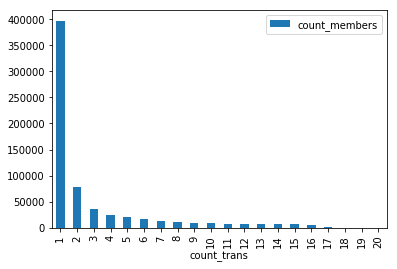

In [39]:
import matplotlib.pyplot as plt
df2.where('count_trans <= 20') \
   .toPandas().set_index('count_trans').plot(kind='bar')

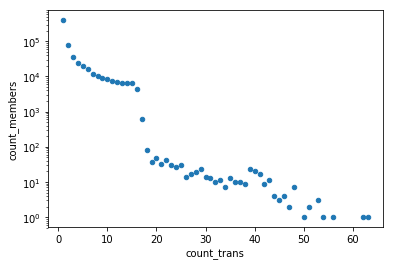

In [42]:
import matplotlib.pyplot as plt
df2.toPandas().plot(kind='scatter', x='count_trans', y='count_members', logy=True)

## total number of subscription days for each member

In [43]:
df1.show(3)

+--------------------+-----------+--------+
|                msno|count_trans|sum_days|
+--------------------+-----------+--------+
|++7jKYbuIJPXry8Oh...|          1|      10|
|+0RJtbyhoPAHPa+34...|          1|     410|
|+3tRPOto/e58mdDA6...|          1|      30|
+--------------------+-----------+--------+
only showing top 3 rows



In [47]:
df1.select(max('sum_days')).show()

+-------------+
|max(sum_days)|
+-------------+
|         2430|
+-------------+



In [46]:
rdd2 = df1.rdd.map(lambda r : r['sum_days'])
rdd2.take(10)

[10, 410, 30, 440, 30, 30, 7, 7, 7, 7]

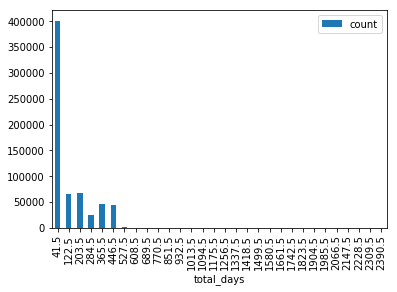

In [65]:
from prepare_hist_data import prepare_histogram_data
import pandas as pd

hist_data = prepare_histogram_data(rdd2, 1, 2431, 30)
pdf = pd.DataFrame(hist_data['bin_centers_counts'], columns=['total_days', 'count']) \
      .set_index('total_days')
pdf.plot(kind='bar')

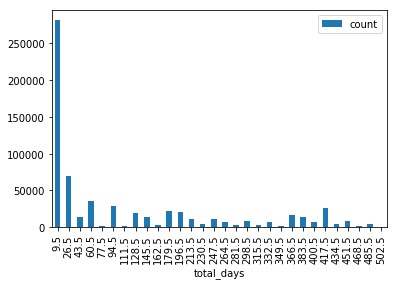

In [66]:
from prepare_hist_data import prepare_histogram_data
import pandas as pd

hist_data = prepare_histogram_data(rdd2, 1, 511, 30)
pdf = pd.DataFrame(hist_data['bin_centers_counts'], columns=['total_days', 'count']) \
      .set_index('total_days')
pdf.plot(kind='bar')

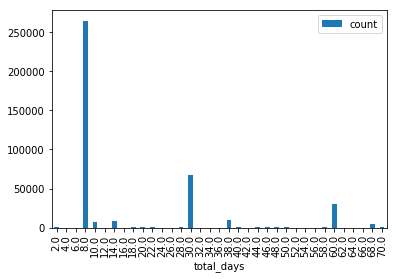

In [67]:
from prepare_hist_data import prepare_histogram_data
import pandas as pd

hist_data = prepare_histogram_data(rdd2, 1, 71, 35)
pdf = pd.DataFrame(hist_data['bin_centers_counts'], columns=['total_days', 'count']) \
      .set_index('total_days')
pdf.plot(kind='bar')

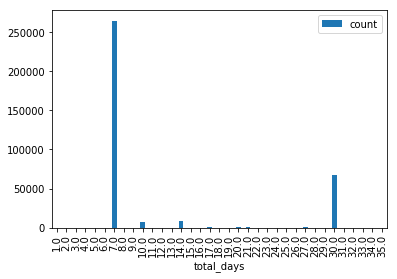

In [69]:
from prepare_hist_data import prepare_histogram_data
import pandas as pd

hist_data = prepare_histogram_data(rdd2, 0.5, 35.5, 35)
pdf = pd.DataFrame(hist_data['bin_centers_counts'], columns=['total_days', 'count']) \
      .set_index('total_days')
pdf.plot(kind='bar')

# exp_date < 2015/01/01

In [11]:
df0.where('exp_date < 20150101').show(10, truncate=False)

+--------------------------------------------+--------------+---------+----------+-----------+----------+--------+
|msno                                        |payment_method|plan_days|list_price|actual_paid|trans_date|exp_date|
+--------------------------------------------+--------------+---------+----------+-----------+----------+--------+
|5dHiSSughrDxCvIFOnwdGyj464eDbw1kj0z5ULaTZL4=|17            |60       |0         |0          |20170125  |19700101|
|L9htK0C5G++25W9s8JHXnlBwidGhkavYB47KLHZUl28=|17            |240      |0         |0          |20170201  |19700101|
|Ojkvmk0tNkDQUAWk2mWlSw4xwZro/Qcs0CXo26q6x/Q=|17            |120      |0         |0          |20170126  |19700101|
|PIKH3Ge8L+SBli3F3HvwVd9yd/ElW7W8FHtoEh44umA=|17            |60       |0         |0          |20170114  |19700101|
|ZXHk5Lkam9yZadqJEf6XIlST8FJbGMsmKtGPidcoLXc=|17            |60       |0         |0          |20170116  |19700101|
|fneCqCp7sETBlpOVE3HKP7bD6QRayxaNlM7KMr3as7U=|17            |60       |0        

In [18]:
from pyspark.sql.functions import col
df0.where(col('msno') == '49YbfSUKgdPqgBNjH++mlFkwNYGF02njbHdwZorvhCA=').show()

+--------------------+--------------+---------+----------+-----------+----------+--------+
|                msno|payment_method|plan_days|list_price|actual_paid|trans_date|exp_date|
+--------------------+--------------+---------+----------+-----------+----------+--------+
|49YbfSUKgdPqgBNjH...|            38|       30|       149|        149|  20161012|20161111|
|49YbfSUKgdPqgBNjH...|            35|        7|         0|          0|  20160827|20160901|
|49YbfSUKgdPqgBNjH...|            38|       30|       149|        149|  20161113|20161213|
|49YbfSUKgdPqgBNjH...|            13|      410|      1788|       1788|  20161219|19700101|
+--------------------+--------------+---------+----------+-----------+----------+--------+



In [10]:
df0.where('exp_date < 20150101') \
   .groupBy('exp_date').count().show()

+--------+-----+
|exp_date|count|
+--------+-----+
|19700101| 1425|
+--------+-----+



In [14]:
df0.where('exp_date < 20150101') \
   .groupBy('list_price', 'actual_paid').count().show()

+----------+-----------+-----+
|list_price|actual_paid|count|
+----------+-----------+-----+
|         0|          0| 1423|
|       894|        894|    1|
|      1788|       1788|    1|
+----------+-----------+-----+



In [16]:
df0.where('exp_date < 20150101') \
   .groupBy('payment_method').count().show()

+--------------+-----+
|payment_method|count|
+--------------+-----+
|            13|    2|
|            17| 1422|
|            35|    1|
+--------------+-----+



* All the records with `exp_date` < 2015-01-01 have `exp_date` = 1970-01-01.
* All (except 2) of the records with `exp_date` < 2015-01-01 have `list_price` = `actual_paid` = 0.
* All (except 3) of the records with `exp_date` < 2015-01-01 have `payment_method` = 17.

In [19]:
df0.where('exp_date < 20150101').count()

1425

In [20]:
df0.where('exp_date < 20150101').groupBy('msno').count().count()

1425

* There are 1425 records with `exp_date` < 20150101.
* There are 1425 members who have records with `exp_date` < 20150101.

In [24]:
df1 = df0.where('exp_date < 20150101').groupBy('msno').count()
df2 = df0.join(df1, df0['msno']==df1['msno'], 'left_semi') \
         .sort('msno', 'trans_date') \
         .persist()
df2.count()

4279

In [26]:
df2.show(10)

# The records of the members who have exp_date < 20150101.

+--------------------+--------------+---------+----------+-----------+----------+--------+
|                msno|payment_method|plan_days|list_price|actual_paid|trans_date|exp_date|
+--------------------+--------------+---------+----------+-----------+----------+--------+
|+7/gCRCtmTgzCPPG9...|            17|      120|         0|          0|  20170124|19700101|
|+7nq1DxnuoR4OyHv2...|            17|       60|         0|          0|  20170203|19700101|
|+8Ic+Vu/CfF0I6AJr...|            17|       60|         0|          0|  20170117|19700101|
|+ANjTMesjelS+V6Hr...|            38|       30|       149|        149|  20151119|20151219|
|+ANjTMesjelS+V6Hr...|            38|      195|       894|        894|  20151225|20160707|
|+ANjTMesjelS+V6Hr...|            38|      195|       894|        894|  20160707|20170118|
|+ANjTMesjelS+V6Hr...|            17|      240|         0|          0|  20170119|19700101|
|+D8fDi3V7uzRdyz4e...|            35|        7|         0|          0|  20161023|20161030|

In [34]:
from pyspark.sql.functions import last
df3 = df2.groupBy('msno').agg(last('exp_date').alias('last_exp_date'))
df3.show(10)

+--------------------+-------------+
|                msno|last_exp_date|
+--------------------+-------------+
|/hpvi2XXLNnTotiDH...|     19700101|
|3ygaUVqXvMCv6OPAB...|     20170301|
|4mPcJNqnIWrDXqapc...|     19700101|
|S5iQ0NdUpAqFAQ8s8...|     20170320|
|SjTMD4QAH/QncTR83...|     19700101|
|Tv6Hzs4tkgBaeAj+0...|     19700101|
|jiCCgxb5Bt9oKrpQW...|     19700101|
|o/bYBfh/CBWqPcegP...|     19700101|
|rdSSmilzcSuz3m8aa...|     19700101|
|1qq279q251/fP44/f...|     19700101|
+--------------------+-------------+
only showing top 10 rows



In [35]:
df3.where('last_exp_date >= 20150101').count()

213

In [36]:
df3.where('last_exp_date = 19700101').count()

1212

* Among the 1425 members who have records with `exp_date` = 19700101, there are exactly 1212 members who have `exp_date` = 19700101 found in their lastest record.

In [40]:
df4 = df3.where('last_exp_date = 19700101')
df5 = df0.join(df4, df0['msno']==df4['msno'], 'left_semi')

In [42]:
outfile = 'file:///home/cloudera/Desktop/KKBox_churn_predict/data01/transactions-v1_members-no-renew_last-expire-1970'
df5.coalesce(1).write.format('csv').option('header', 'true').save(outfile)

## [cl2] remove members having a record with exp_date = 1970-01-01

In [6]:
df0.printSchema()

root
 |-- msno: string (nullable = true)
 |-- payment_method: integer (nullable = true)
 |-- plan_days: integer (nullable = true)
 |-- list_price: integer (nullable = true)
 |-- actual_paid: integer (nullable = true)
 |-- trans_date: integer (nullable = true)
 |-- exp_date: integer (nullable = true)



In [13]:
df_badmem = df0.where('exp_date = 19700101').groupBy('msno').count() \
              .select('msno') \
              .persist()
df_badmem.count()

1425

In [14]:
df0_cl2 = df0.join(df_badmem, df0['msno']==df_badmem['msno'], 'left_anti')
df0_cl2.printSchema()

root
 |-- msno: string (nullable = true)
 |-- payment_method: integer (nullable = true)
 |-- plan_days: integer (nullable = true)
 |-- list_price: integer (nullable = true)
 |-- actual_paid: integer (nullable = true)
 |-- trans_date: integer (nullable = true)
 |-- exp_date: integer (nullable = true)



In [16]:
df0_cl2.count()

1816863

In [15]:
outfile = dir0 + 'transactions-v1_members-no-renew_cl2'
df0_cl2.write.format('csv').option('header', 'true').save(outfile)

# trans_date, exp_date, and start date (cl2)

In [3]:
infile = dir0 + 'transactions-v1_members-no-renew_cl2'
df0_cl2 = spark.read.format('csv').option('header','true').option('inferSchema', 'true').load(infile)
df0_cl2.printSchema()

root
 |-- msno: string (nullable = true)
 |-- payment_method: integer (nullable = true)
 |-- plan_days: integer (nullable = true)
 |-- list_price: integer (nullable = true)
 |-- actual_paid: integer (nullable = true)
 |-- trans_date: integer (nullable = true)
 |-- exp_date: integer (nullable = true)



In [4]:
df0_cl2.show(3)

+--------------------+--------------+---------+----------+-----------+----------+--------+
|                msno|payment_method|plan_days|list_price|actual_paid|trans_date|exp_date|
+--------------------+--------------+---------+----------+-----------+----------+--------+
|nuNWXAG/T41m2CTNT...|            38|       30|       149|        149|  20160125|20160224|
|nuNWXAG/T41m2CTNT...|            38|       30|       149|        149|  20160609|20160709|
|nuNWXAG/T41m2CTNT...|            38|       30|       149|        149|  20151120|20151220|
+--------------------+--------------+---------+----------+-----------+----------+--------+
only showing top 3 rows



In [5]:
df0_cl2.count()

1816863

In [16]:
df0_cl2.groupBy('msno').count().count()

649618

In [5]:
from calendar import monthrange
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf, col

def get_start_date(exp_date_int, plan_days):
    '''
    Returns an integer.
    '''
    if plan_days == 360:
        pl_yrs = 0
        pl_mns = 11
        pl_days = 25
    else:
        pl_yrs = plan_days // 365
        pl_mns = (plan_days % 365) // 30
        pl_days = (plan_days % 365) % 30
    
    exp_yr = exp_date_int // 10000
    exp_mn = (exp_date_int % 10000) // 100
    exp_day = exp_date_int % 100
    
    yr = exp_yr - pl_yrs
    mn = exp_mn - pl_mns
    day = exp_day - pl_days
    
    while mn < 1:
        mn += 12
        yr -= 1
    
    while day < 1:
        if mn == 1:
            Nd = monthrange(yr-1, 12)[1]
        else:
            Nd = monthrange(yr, mn-1)[1]
        mn -= 1
        day += Nd
        if mn == 0:
            mn = 12
            yr -= 1

    day += 1
    Nd = monthrange(yr, mn)[1]
    if day > Nd:
        day -= Nd
        mn += 1
        if mn == 13:
            mn = 1
            yr += 1
    
    return yr*10000 + mn*100 + day

f_get_start_date = udf(get_start_date, IntegerType())

df1 = df0_cl2.withColumn('start_date', f_get_start_date(col('exp_date'), col('plan_days')))
df1.show(10)

+--------------------+--------------+---------+----------+-----------+----------+--------+----------+
|                msno|payment_method|plan_days|list_price|actual_paid|trans_date|exp_date|start_date|
+--------------------+--------------+---------+----------+-----------+----------+--------+----------+
|nuNWXAG/T41m2CTNT...|            38|       30|       149|        149|  20160125|20160224|  20160125|
|nuNWXAG/T41m2CTNT...|            38|       30|       149|        149|  20160609|20160709|  20160610|
|nuNWXAG/T41m2CTNT...|            38|       30|       149|        149|  20151120|20151220|  20151121|
|nuNWXAG/T41m2CTNT...|            38|       30|       149|        149|  20160403|20160503|  20160404|
|nuNWXAG/T41m2CTNT...|            38|       30|       149|        149|  20170213|20170315|  20170216|
|nvH4in4HHNK3KtuEf...|            29|       30|       180|        180|  20160913|20161013|  20160914|
|nvwfeQ2rTuD5olmw2...|            38|       30|       149|        149|  20160102|2

In [6]:
from pyspark.sql.functions import col, to_date
df2 = df1.select('msno', 'payment_method', 'list_price', 'actual_paid', 'plan_days', 
                 to_date(col('trans_date').cast('string'), 'yyyyMMdd').alias('trans_date'),
                 to_date(col('exp_date').cast('string'), 'yyyyMMdd').alias('exp_date'),
                 to_date(col('start_date').cast('string'), 'yyyyMMdd').alias('start_date')
                )
df2.show(10)

+--------------------+--------------+----------+-----------+---------+----------+----------+----------+
|                msno|payment_method|list_price|actual_paid|plan_days|trans_date|  exp_date|start_date|
+--------------------+--------------+----------+-----------+---------+----------+----------+----------+
|nuNWXAG/T41m2CTNT...|            38|       149|        149|       30|2016-01-25|2016-02-24|2016-01-25|
|nuNWXAG/T41m2CTNT...|            38|       149|        149|       30|2016-06-09|2016-07-09|2016-06-10|
|nuNWXAG/T41m2CTNT...|            38|       149|        149|       30|2015-11-20|2015-12-20|2015-11-21|
|nuNWXAG/T41m2CTNT...|            38|       149|        149|       30|2016-04-03|2016-05-03|2016-04-04|
|nuNWXAG/T41m2CTNT...|            38|       149|        149|       30|2017-02-13|2017-03-15|2017-02-16|
|nvH4in4HHNK3KtuEf...|            29|       180|        180|       30|2016-09-13|2016-10-13|2016-09-14|
|nvwfeQ2rTuD5olmw2...|            38|       149|        149|    

## start_date relative to trans_date

In [7]:
from pyspark.sql.functions import col, datediff
df3 = df2.select('msno', 'payment_method', 'list_price', 'actual_paid',
                 'plan_days', 'trans_date', 'start_date', 'exp_date',
                 datediff('start_date', 'trans_date').alias('start_minus_trans'))
df3.show(10)

+--------------------+--------------+----------+-----------+---------+----------+----------+----------+-----------------+
|                msno|payment_method|list_price|actual_paid|plan_days|trans_date|start_date|  exp_date|start_minus_trans|
+--------------------+--------------+----------+-----------+---------+----------+----------+----------+-----------------+
|nuNWXAG/T41m2CTNT...|            38|       149|        149|       30|2016-01-25|2016-01-25|2016-02-24|                0|
|nuNWXAG/T41m2CTNT...|            38|       149|        149|       30|2016-06-09|2016-06-10|2016-07-09|                1|
|nuNWXAG/T41m2CTNT...|            38|       149|        149|       30|2015-11-20|2015-11-21|2015-12-20|                1|
|nuNWXAG/T41m2CTNT...|            38|       149|        149|       30|2016-04-03|2016-04-04|2016-05-03|                1|
|nuNWXAG/T41m2CTNT...|            38|       149|        149|       30|2017-02-13|2017-02-16|2017-03-15|                3|
|nvH4in4HHNK3KtuEf...|  

In [49]:
from pyspark.sql.functions import min, max
df3.select(min('start_minus_trans'), max('start_minus_trans')).show()

+----------------------+----------------------+
|min(start_minus_trans)|max(start_minus_trans)|
+----------------------+----------------------+
|                  -412|                   471|
+----------------------+----------------------+



In [42]:
df3.where('start_minus_trans < -10').count()

3587

In [43]:
3587/1816863*100

0.197428204548169

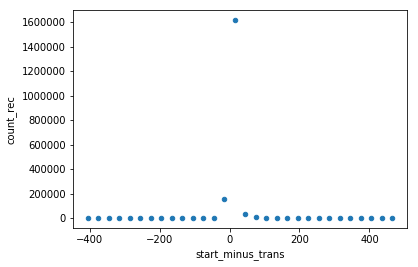

In [25]:
from prepare_hist_data import prepare_histogram_data
import pandas as pd
import matplotlib.pyplot as plt

rdd4 = df3.rdd.map(lambda r: r['start_minus_trans'])
hist_data = prepare_histogram_data(rdd4, -420, 480, 30)

pd.DataFrame(hist_data['bin_centers_counts'], columns=['start_minus_trans', 'count_rec']) \
  .plot(kind='scatter', x='start_minus_trans', y='count_rec')
plt.show()

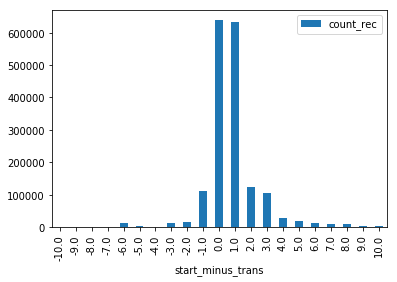

In [29]:
from prepare_hist_data import prepare_histogram_data
import pandas as pd
import matplotlib.pyplot as plt

rdd4 = df3.rdd.map(lambda r: r['start_minus_trans'])
hist_data = prepare_histogram_data(rdd4, -10.5, 10.5, 21)

pd.DataFrame(hist_data['bin_centers_counts'], columns=['start_minus_trans', 'count_rec']) \
  .set_index('start_minus_trans') \
  .plot(kind='bar')
plt.show()

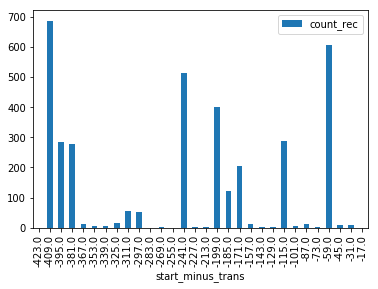

In [32]:
from prepare_hist_data import prepare_histogram_data
import pandas as pd
import matplotlib.pyplot as plt

rdd4 = df3.rdd.map(lambda r: r['start_minus_trans'])
hist_data = prepare_histogram_data(rdd4, -430, -10, 30)

pd.DataFrame(hist_data['bin_centers_counts'], columns=['start_minus_trans', 'count_rec']) \
  .set_index('start_minus_trans') \
  .plot(kind='bar')
plt.show()

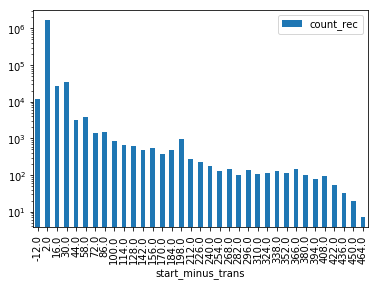

In [36]:
from prepare_hist_data import prepare_histogram_data
import pandas as pd
import matplotlib.pyplot as plt

rdd4 = df3.rdd.map(lambda r: r['start_minus_trans'])
hist_data = prepare_histogram_data(rdd4, -19, 471, 35)

pd.DataFrame(hist_data['bin_centers_counts'], columns=['start_minus_trans', 'count_rec']) \
  .set_index('start_minus_trans') \
  .plot(kind='bar', logy=True)
plt.show()

### start_date >> trans_date

In [50]:
df3.where('start_minus_trans = 400').show(5, truncate=False)

+--------------------------------------------+---------+----------+----------+----------+-----------------+
|msno                                        |plan_days|trans_date|start_date|exp_date  |start_minus_trans|
+--------------------------------------------+---------+----------+----------+----------+-----------------+
|8DFvuW6QT8NDXa2/yrvEdpzz/oLoKWaHNUt65vHd3nM=|10       |2015-12-17|2017-01-20|2017-01-29|400              |
|4AAR0jLOIpX9HlUCXdHJWSO38ZeAHv9quwjyOXtxKR4=|1        |2015-12-01|2017-01-04|2017-01-04|400              |
|Mjp5uPtRQPFUiMfw+rWecb2EGoo69dc6t1gSBRgz60c=|7        |2015-12-14|2017-01-17|2017-01-23|400              |
|gm4cJ6TsWu8U8P8NvXrck+c0K6PeNv62zIZp8Oc45q4=|10       |2015-12-24|2017-01-27|2017-02-05|400              |
|HmzY3pwOW5pnzM2VZRdxsbwNKdgar6QGFqVvYtdLHyI=|10       |2015-12-15|2017-01-18|2017-01-27|400              |
+--------------------------------------------+---------+----------+----------+----------+-----------------+



In [41]:
df1.where(col('msno') == 'Mjp5uPtRQPFUiMfw+rWecb2EGoo69dc6t1gSBRgz60c=') \
  .sort('trans_date').show(50)

+--------------------+--------------+---------+----------+-----------+----------+--------+----------+
|                msno|payment_method|plan_days|list_price|actual_paid|trans_date|exp_date|start_date|
+--------------------+--------------+---------+----------+-----------+----------+--------+----------+
|Mjp5uPtRQPFUiMfw+...|            20|      100|       480|        480|  20151107|20160215|  20151106|
|Mjp5uPtRQPFUiMfw+...|            38|        7|        35|         35|  20151116|20160222|  20160216|
|Mjp5uPtRQPFUiMfw+...|            38|        7|         0|          0|  20151213|20160530|  20160524|
|Mjp5uPtRQPFUiMfw+...|            38|        7|         0|          0|  20151213|20160307|  20160301|
|Mjp5uPtRQPFUiMfw+...|            38|        7|         0|          0|  20151213|20160425|  20160419|
|Mjp5uPtRQPFUiMfw+...|            38|        7|         0|          0|  20151213|20160523|  20160517|
|Mjp5uPtRQPFUiMfw+...|            38|        7|         0|          0|  20151213|2

### start_date << trans_date

In [51]:
df3.where('start_minus_trans = -400').show(5, truncate=False)

+--------------------------------------------+---------+----------+----------+----------+-----------------+
|msno                                        |plan_days|trans_date|start_date|exp_date  |start_minus_trans|
+--------------------------------------------+---------+----------+----------+----------+-----------------+
|8h9YcPY3QCRduzkyiB2xAHcYe+wUXxenUGu5x7V8wbo=|410      |2016-01-14|2014-12-10|2016-01-24|-400             |
|KZY3caQbSjku6Pg9Mgzob5tQpXUIfXskXSoTku1rnlU=|410      |2016-07-11|2015-06-07|2016-07-21|-400             |
|Tm7AA7LujrO10l8w3K4x39dvRnXpYq6+d3G5U5q8O9g=|410      |2016-04-02|2015-02-27|2016-04-13|-400             |
|1zTNkkL4LuOTWUGtIvLCYJvdC+aa4zyZE3GVtO0LYe8=|410      |2016-10-04|2015-08-31|2016-10-14|-400             |
|mb7vitb8aho6mmwNhd+UAJ+6Vh60JybAWohtrwOMeFU=|410      |2016-11-27|2015-10-24|2016-12-07|-400             |
+--------------------------------------------+---------+----------+----------+----------+-----------------+
only showing top 5 rows



In [44]:
df1.where(col('msno') == 'yvFIrYwGjxQx6TxNUybmWBbLLtGAvHR3upwGDKR5XAg=') \
  .sort('trans_date').show()

+--------------------+--------------+---------+----------+-----------+----------+--------+----------+
|                msno|payment_method|plan_days|list_price|actual_paid|trans_date|exp_date|start_date|
+--------------------+--------------+---------+----------+-----------+----------+--------+----------+
|yvFIrYwGjxQx6TxNU...|            17|      410|         0|          0|  20151125|20151204|  20141021|
|yvFIrYwGjxQx6TxNU...|            15|      410|      1788|       1788|  20151126|20170120|  20151206|
|yvFIrYwGjxQx6TxNU...|            17|      395|         0|          0|  20170117|20170123|  20151224|
+--------------------+--------------+---------+----------+-----------+----------+--------+----------+



### list_price

In [9]:
df3.where('start_minus_trans < -7') \
   .groupBy('list_price').count().show(50)

+----------+-----+
|list_price|count|
+----------+-----+
|      1599|    1|
|       699|    1|
|       894|    2|
|         0| 3586|
+----------+-----+



* Almost all of the records with `start_minus_trans` < -7 have `list_price` = 0.

In [11]:
df3.where('start_minus_trans < -7').where('list_price > 0').show(truncate=False)

+--------------------------------------------+----------+---------+----------+----------+----------+-----------------+
|msno                                        |list_price|plan_days|trans_date|start_date|exp_date  |start_minus_trans|
+--------------------------------------------+----------+---------+----------+----------+----------+-----------------+
|HgOJ6bYyJ9DoiCQEiJ+xEnTR7RBYVUWrsnW+A5S9ZZo=|699       |180      |2016-12-19|2016-06-20|2016-12-19|-182             |
|lInYU/0NjIBPUPT0KBPESV3rNgEoIazeXiX85VJkeNQ=|894       |270      |2016-12-20|2016-03-21|2016-12-20|-274             |
|MfTzQmIq1XtYsAbb6uElpfaa2/GZy+TsWD0wfrRIFvM=|1599      |415      |2016-12-19|2015-11-03|2016-12-22|-412             |
|lvDSawNlJoTlNd2ykkGOgJzfEcnlYohlqZSJWcRRhC0=|894       |195      |2016-03-22|2016-02-24|2016-09-09|-27              |
+--------------------------------------------+----------+---------+----------+----------+----------+-----------------+



### vs. plan_days

In [57]:
from pyspark.sql.functions import min
df3.where('plan_days = 1') \
  .select(min('start_minus_trans')).show()

+----------------------+
|min(start_minus_trans)|
+----------------------+
|                    -8|
+----------------------+



In [58]:
from pyspark.sql.functions import min
df3.where('plan_days = 7') \
  .select(min('start_minus_trans')).show()

+----------------------+
|min(start_minus_trans)|
+----------------------+
|                    -9|
+----------------------+



In [64]:
from pyspark.sql.functions import min
df4 = df3.groupBy('plan_days').agg(min('start_minus_trans').alias('min__start_minus_trans'),
                                   max('start_minus_trans').alias('max__start_minus_trans')) \
        .sort('plan_days')
df5 = df4.toPandas()

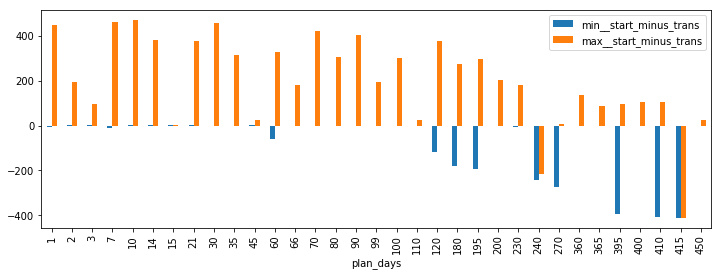

In [68]:
df5.set_index('plan_days') \
  .plot(kind='bar', figsize=(12,4))

### start_date - trans_date < -7

In [101]:
from pyspark.sql.functions import min, datediff
df4 = df3.where('start_minus_trans < -7') \
        .select(datediff('exp_date', 'trans_date').alias('exp_minus_trans'))
df4.describe().show()

+-------+------------------+
|summary|   exp_minus_trans|
+-------+------------------+
|  count|              3590|
|   mean| 8.442061281337047|
| stddev|18.428609996694988|
|    min|                -8|
|    max|               303|
+-------+------------------+



In [93]:
df4.where('exp_minus_trans < 0').count()

3

### [cl3] modify start_date
If `start_date` < `trans_date`- 7, set `start_date` = `trans_date`- 8.

In [8]:
df3.where('start_minus_trans < -7').count()

3590

In [10]:
df3.where('start_minus_trans < -7') \
   .groupBy('msno').count().count()

3514

* 3590 records (0.2 %) will be affected.
* 3514 members (0.5 %) will be affected.

In [10]:
df3.show(1)

+--------------------+--------------+----------+-----------+---------+----------+----------+----------+-----------------+
|                msno|payment_method|list_price|actual_paid|plan_days|trans_date|start_date|  exp_date|start_minus_trans|
+--------------------+--------------+----------+-----------+---------+----------+----------+----------+-----------------+
|nuNWXAG/T41m2CTNT...|            38|       149|        149|       30|2016-01-25|2016-01-25|2016-02-24|                0|
+--------------------+--------------+----------+-----------+---------+----------+----------+----------+-----------------+
only showing top 1 row



In [16]:
from pyspark.sql.functions import when, col, date_sub
df4 = df3.withColumn('start_date_2',
                     when(col('start_minus_trans') < -7, 
                          date_sub('trans_date', 8)
                         ) \
                     .otherwise(col('start_date'))
                    )

In [17]:
df4.show(1)

+--------------------+--------------+----------+-----------+---------+----------+----------+----------+-----------------+------------+
|                msno|payment_method|list_price|actual_paid|plan_days|trans_date|start_date|  exp_date|start_minus_trans|start_date_2|
+--------------------+--------------+----------+-----------+---------+----------+----------+----------+-----------------+------------+
|nuNWXAG/T41m2CTNT...|            38|       149|        149|       30|2016-01-25|2016-01-25|2016-02-24|                0|  2016-01-25|
+--------------------+--------------+----------+-----------+---------+----------+----------+----------+-----------------+------------+
only showing top 1 row



In [19]:
df4.where('start_minus_trans < -7').limit(1).show()

+--------------------+--------------+----------+-----------+---------+----------+----------+----------+-----------------+------------+
|                msno|payment_method|list_price|actual_paid|plan_days|trans_date|start_date|  exp_date|start_minus_trans|start_date_2|
+--------------------+--------------+----------+-----------+---------+----------+----------+----------+-----------------+------------+
|o60m5gVKt781OJ9z+...|            17|         0|          0|      195|2016-05-24|2015-11-13|2016-05-27|             -193|  2016-05-16|
+--------------------+--------------+----------+-----------+---------+----------+----------+----------+-----------------+------------+



In [22]:
outfile = dir0 + 'transactions-v1_members-no-renew_cl3'
df4.drop('start_minus_trans').drop('start_date') \
   .withColumnRenamed('start_date_2', 'start_date') \
   .write.format('csv').option('header', 'true').save(outfile)